Sınıf dağılımı:
Duygu Etiketi
negative    3026
positive    2854
Name: count, dtype: int64


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-turkish-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Auc
1,No log,0.701783,0.506803,0.506803,1.000000,0.672686,0.500000
2,0.708100,0.690210,0.507653,0.507259,0.996644,0.672326,0.500908
3,0.708100,0.429723,0.812925,0.912281,0.697987,0.790875,0.814511
4,0.528700,0.304153,0.878401,0.933078,0.818792,0.872207,0.879224
5,0.528700,0.390832,0.881803,0.905861,0.855705,0.880069,0.882163


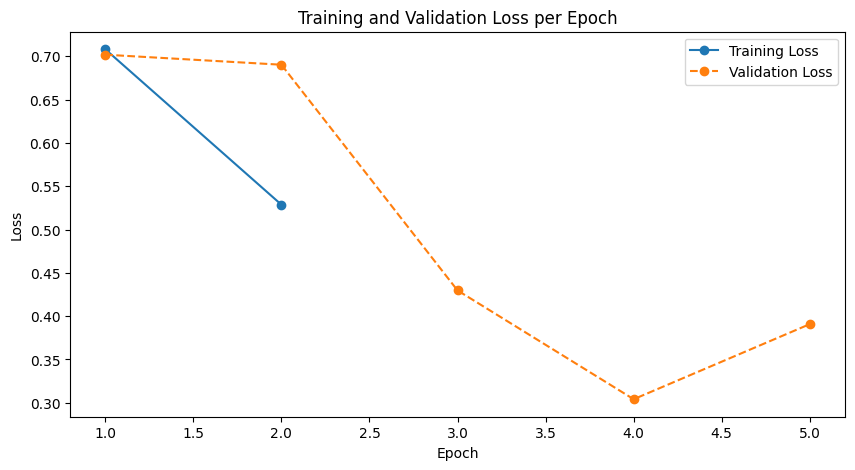

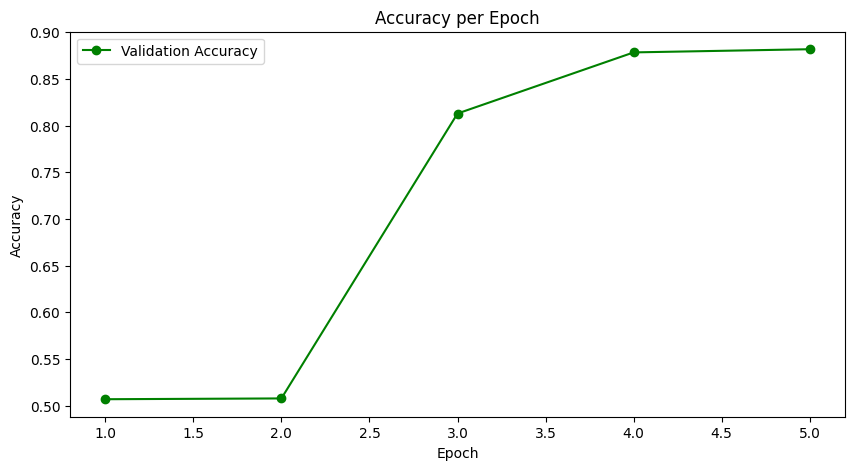

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from datasets import Dataset
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

# 1. Veriyi yükle
file_path = "All_Scrapping_Corrected_Sentiment_Labels.csv"
data = pd.read_csv(file_path)

# Veri seti hakkında bilgi
print("Sınıf dağılımı:")
print(data['Duygu Etiketi'].value_counts())

# 2. Eğitim ve test setlerini oluştur
train_texts, test_texts, train_labels, test_labels = train_test_split(
    data['Yorum Temiz'].tolist(),
    data['Duygu Etiketi'].map({'positive': 1, 'negative': 0}).tolist(),
    test_size=0.2,
    random_state=42
)

# 3. Tokenizer ile veri hazırlama
model_name = "dbmdz/bert-base-turkish-cased"
tokenizer = BertTokenizer.from_pretrained(model_name)

def tokenize_function(texts):
    return tokenizer(texts, padding="max_length", truncation=True, max_length=512)

train_encodings = tokenize_function(train_texts)
test_encodings = tokenize_function(test_texts)

train_dataset = Dataset.from_dict({'input_ids': train_encodings['input_ids'], 'labels': train_labels})
test_dataset = Dataset.from_dict({'input_ids': test_encodings['input_ids'], 'labels': test_labels})

# 4. Modeli tanımla
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

# 5. GPU cihazını tanımla
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

# 6. Eğitim ayarlarını yap
training_args = TrainingArguments(
    output_dir="./results",  # Model sonuçlarını kaydedecek dizin
    num_train_epochs=5,  # Eğitim döngüsü sayısı
    per_device_train_batch_size=16,  # Eğitimde cihaz başına batch boyutu
    per_device_eval_batch_size=64,  # Değerlendirme için batch boyutu
    warmup_steps=500,  # Öğrenme oranı için warmup adımları
    weight_decay=0.01,  # Ağırlık azaltma
    logging_dir="./logs",  # Log dosyalarını kaydedecek dizin
    eval_strategy="epoch",  # Her epoch sonrası değerlendirme
    dataloader_num_workers=4,  # Data yüklemesi için iş parçacığı sayısı
    fp16=True if torch.cuda.is_available() else False,  # GPU kullanımı için float16
)

# 7. Performans metriklerini hesaplama fonksiyonu
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary', zero_division=0)
    acc = accuracy_score(labels, preds)
    auc = roc_auc_score(labels, preds) if len(set(labels)) > 1 else 0.5
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1, "auc": auc}

# 8. Modeli eğit ve değerlendir
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()

# 9. Eğitim sırasında kaydedilen metrikleri alın
metrics = trainer.state.log_history

# Loss ve Accuracy metriklerini ayıkla
training_loss = [m.get("loss", None) for m in metrics if "loss" in m]
validation_loss = [m.get("eval_loss", None) for m in metrics if "eval_loss" in m]
accuracy = [m.get("eval_accuracy", None) for m in metrics if "eval_accuracy" in m]

# Epoch sayısını belirleyin
epochs_training = range(1, len(training_loss) + 1)
epochs_validation = range(1, len(validation_loss) + 1)

# 10. Loss Grafiği
plt.figure(figsize=(10, 5))
plt.plot(epochs_training, training_loss, label="Training Loss", marker='o')
plt.plot(epochs_validation, validation_loss, label="Validation Loss", marker='o', linestyle='--')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss per Epoch")
plt.legend()
plt.savefig("loss_per_epoch.png")
plt.show()

# 11. Accuracy Grafiği
valid_epochs = range(1, len(accuracy) + 1)
valid_accuracy = [acc for acc in accuracy if acc is not None]

plt.figure(figsize=(10, 5))
plt.plot(valid_epochs, valid_accuracy, label="Validation Accuracy", color="green", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per Epoch")
plt.legend()
plt.savefig("accuracy_per_epoch.png")
plt.show()

# 12. Sonuçları değerlendir
predictions = trainer.predict(test_dataset)
print("Performans:", predictions.metrics)

# Confusion Matrix
pred_labels = np.argmax(predictions.predictions, axis=1)
cm = confusion_matrix(test_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])

plt.figure(figsize=(8, 8))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix.png")
plt.show()

# 13. Sonuçları kaydet
results_df = pd.DataFrame(predictions.metrics, index=[0])
results_df.to_csv("bert_model_results.csv", index=False)
